Drive Link: https://drive.google.com/drive/folders/1eWJ1b3byqFa_wOqIlNNVxADm-VlCikJu?usp=sharing

Medium Link: https://medium.com/p/97c6a19e3f0b/edit

# Notebook Imports


In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import math

sns.set_style("dark")

# Reading Data

In [240]:
df = pd.read_csv("data/cleaned_data.csv", index_col=0)
df = df.drop(columns=["title"])
df.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ET
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,T


# Splitting Dataset


In [241]:
encoding = {"E": 0, "ET": 1, "T": 2, "M": 3}
df.esrb_rating = df.esrb_rating.replace(encoding)

We remove the variables with abs(correlation) < 0.2

# Feature Selection

We need to select features which have the highest importance in determining the output. For this we could look at a couple of methods as outlined below

### Based on Correlation Factors

In [242]:
# train, val = train_test_split(df, test_size=0.2)
train = df.copy()

In [243]:
columns_to_keep = (
    train.corr().esrb_rating.sort_values(key=lambda x: abs(x))[::-1][0:11].index
)
# columns_to_keep

train = train[columns_to_keep]
train.shape

(1889, 11)

In [244]:
# train.corr().esrb_rating.sort_values(key= lambda x: abs(x))

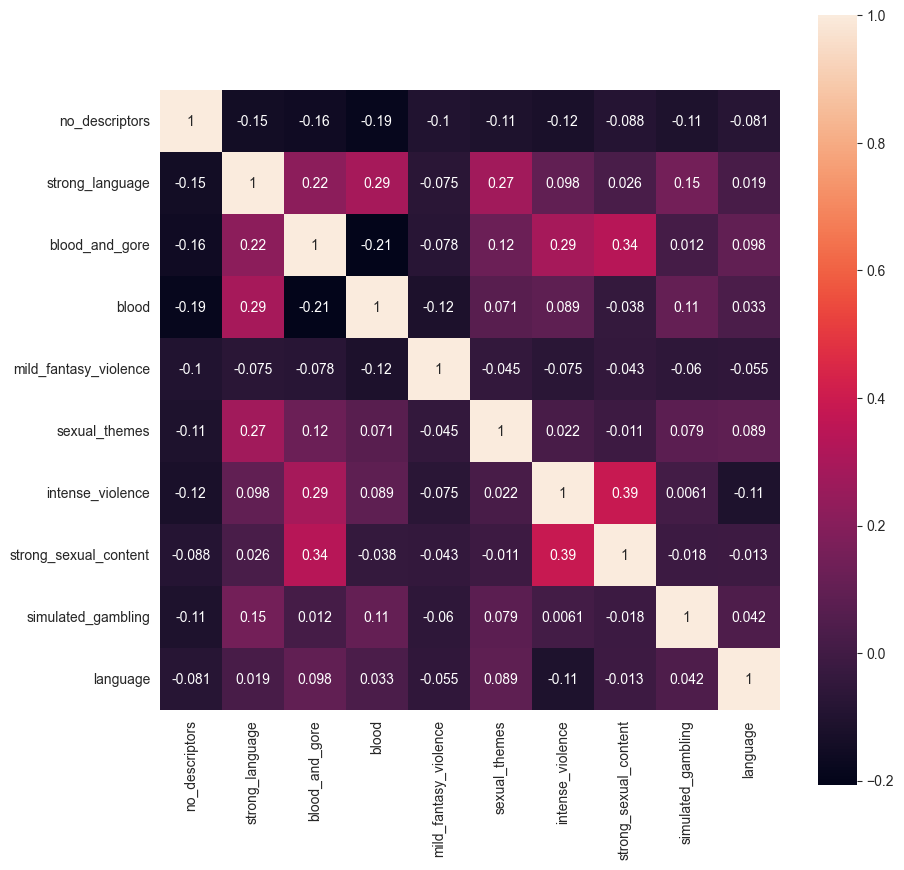

In [245]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.drop(columns="esrb_rating").corr(), square=True, annot=True)
plt.show()

We plot the KDE plots of each of these variables given each class / ESRB_rating

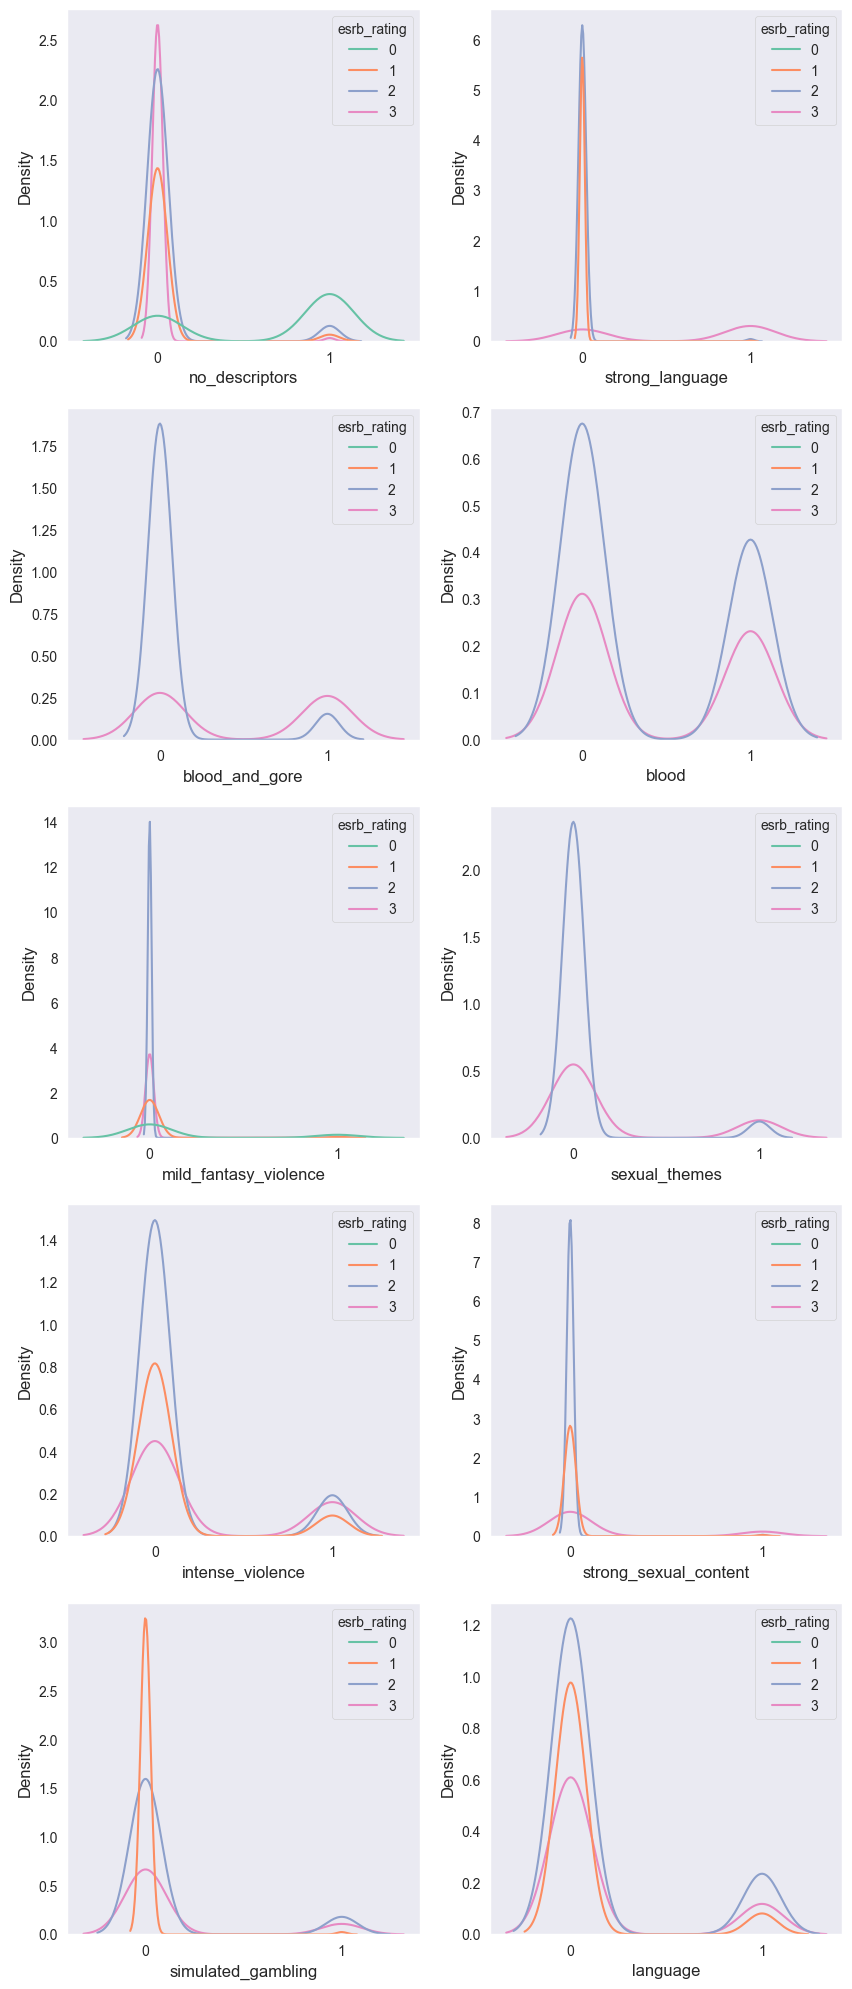

In [246]:
fig, axes = plt.subplots(5, 2, figsize=(10, 25))
axes = axes.flatten()
# print(len(train.columns))
for ax, col in zip(axes, train.drop(columns="esrb_rating").columns):
    sns.kdeplot(
        data=train, x=col, hue="esrb_rating", ax=ax, palette="Set2", warn_singular=False
    )
    ax.set_xticks([0, 1])

plt.show()


From the above plots, we can see that for all the selected explanatory variables, data is mostly distributed towards 0 for all 4 classes. 

This means that for any variable, the probability of that variable being 1 is significantly lower than the probability of that variable being 0. 

Perhaps it would be fruitful to choose some other form of selecting variables for our classifier model

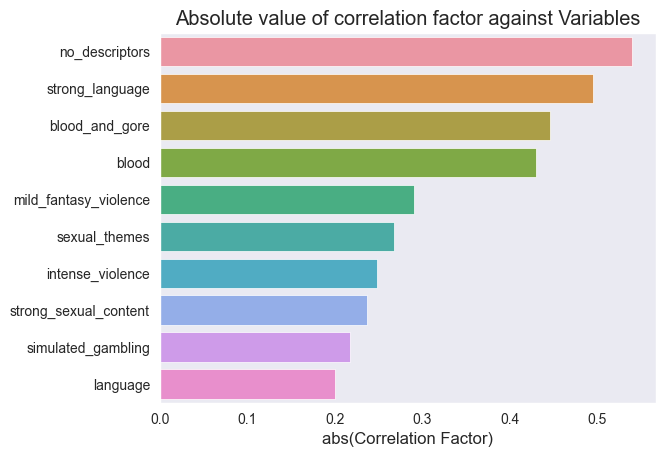

In [247]:
# plotting bar plot of correlatiosn with esrb_rating
sns.barplot(
    x=abs(train.corr().esrb_rating.sort_values(key=lambda x: abs(x))[::-1].values[1:]),
    y=train.columns[1:],
)
plt.title("Absolute value of correlation factor against Variables")
plt.xlabel("abs(Correlation Factor)")
plt.show()

In [248]:
# saving data to csv
train.to_csv("data/correlation-training.csv")

# Random Forests

In [249]:
train = df.copy()

In [250]:
from sklearn.ensemble import RandomForestClassifier

In [251]:
train_x = train.drop(columns="esrb_rating")
train_y = train.esrb_rating

max_depth = math.ceil(0.3 * len(train_x.columns))

forest = model = RandomForestClassifier(
    n_estimators=300, max_depth=max_depth, random_state=1, criterion="gini"
).fit(train_x, train_y)

In [252]:
feature_imp = pd.Series(model.feature_importances_, index=train_x.columns).sort_values(
    ascending=False
)


In [366]:

feature_imp = feature_imp[:10]
feature_imp


no_descriptors           0.175864
strong_language          0.163831
fantasy_violence         0.103306
blood                    0.100125
blood_and_gore           0.087517
mild_fantasy_violence    0.048528
suggestive_themes        0.032760
violence                 0.027555
language                 0.026309
strong_sexual_content    0.024438
dtype: float64

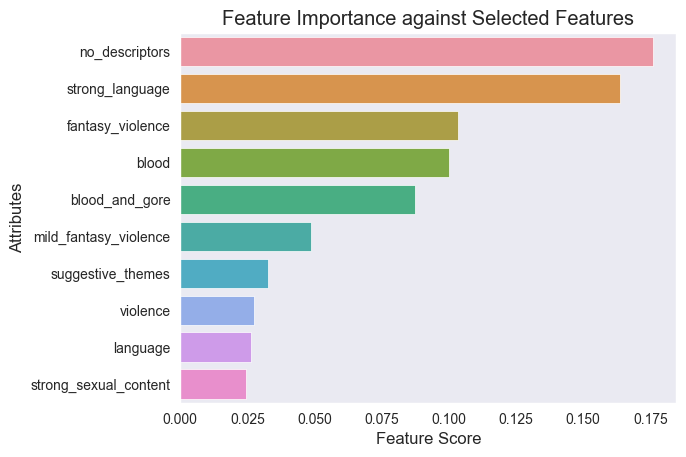

In [254]:

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Feature Score")
plt.ylabel("Attributes")
plt.title("Feature Importance against Selected Features")
# plt.legend()
plt.show()

plt.show()

In [255]:
train.to_csv("data/rf-training.csv")

# Machine Learning

In [262]:
corr_train = pd.read_csv("data/correlation-training.csv", index_col=0)
rf_train = pd.read_csv("data/rf-training.csv", index_col=0)

## Using Correlation Factor features

### 1. Support Vector Machine

In [280]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv # needed for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [295]:
train_x = corr_train.drop(columns="esrb_rating")
train_y = corr_train["esrb_rating"]

ENCODING_LABELS = list(encoding.keys())

#### Finding Best Parameters for SVM

We define a range of values for different parameters for the SVM model, such as regularization parameter C = np.linspace(0.1, 100, 10). We then use HalvingGridSearchCV to exhaustively find the best parameters from these ranges. 

In [282]:
C = np.linspace(0.1, 100, 10)
degree = [2, 3, 4, 5, 6]
gamma = list(np.round(np.linspace(0.1, 10, 10), 3))
gamma.append('scale')
gamma.append('auto')
kernel = ['poly', 'rbf', 'sigmoid']

param_grid = {'C': C, 'degree': degree, 'gamma': gamma, 'kernel': kernel}
print(param_grid)

{'C': array([  0.1,  11.2,  22.3,  33.4,  44.5,  55.6,  66.7,  77.8,  88.9,
       100. ]), 'degree': [2, 3, 4, 5, 6], 'gamma': [0.1, 1.2, 2.3, 3.4, 4.5, 5.6, 6.7, 7.8, 8.9, 10.0, 'scale', 'auto'], 'kernel': ['poly', 'rbf', 'sigmoid']}


In [283]:
svm_model = HalvingGridSearchCV(
    SVC(), 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=20,
    refit=True,
)

svm_model.fit(train_x, train_y)

HalvingGridSearchCV(estimator=SVC(), n_jobs=20,
                    param_grid={'C': array([  0.1,  11.2,  22.3,  33.4,  44.5,  55.6,  66.7,  77.8,  88.9,
       100. ]),
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.1, 1.2, 2.3, 3.4, 4.5, 5.6, 6.7,
                                          7.8, 8.9, 10.0, 'scale', 'auto'],
                                'kernel': ['poly', 'rbf', 'sigmoid']},
                    scoring='accuracy')

The best parameters have been found:

In [284]:
print("Best parameters:", svm_model.best_params_)
best_svm_model = svm_model.best_estimator_

Best parameters: {'C': 66.7, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}


#### Testing Pipeline

Precision, Recall, Accuracy and confusion matrix can all be seen here. As evident by the results, the model performs very well

In [292]:
test_df = pd.read_csv("data/test_esrb.csv")[corr_train.columns]
test_df.esrb_rating = test_df.esrb_rating.replace(encoding)

test_x = test_df.drop(['esrb_rating'], axis=1)
test_y = test_df['esrb_rating']

              precision    recall  f1-score   support

           E       0.91      0.74      0.82       100
          ET       0.58      0.91      0.71       126
           T       0.77      0.63      0.69       184
           M       0.90      0.70      0.79        90

    accuracy                           0.74       500
   macro avg       0.79      0.75      0.75       500
weighted avg       0.77      0.74      0.74       500



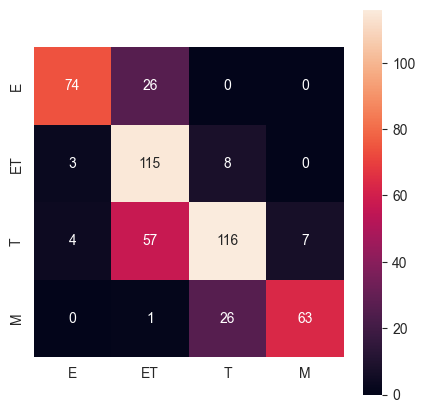

In [294]:
preds = best_svm_model.predict(test_x)
print(classification_report(test_y, preds, target_names=ENCODING_LABELS))

cfm = confusion_matrix(test_y, preds)

plt.figure(figsize=(5, 5))
sns.heatmap(pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
            annot=True, fmt='d', square=True)
pass

### 2. kNN

Making test and train data and labels

In [308]:
train_x = corr_train.drop(columns="esrb_rating")
train_y = corr_train["esrb_rating"]

In [309]:
test_df = pd.read_csv("data/test_esrb.csv")[corr_train.columns]
test_df.esrb_rating = test_df.esrb_rating.replace(encoding)

test_x = test_df.drop(['esrb_rating'], axis=1)
test_y = test_df['esrb_rating']

Using k-fold cross-validation with k from 1 to 20.

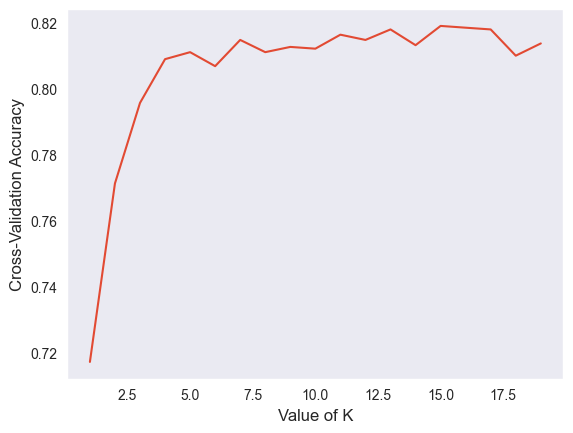

In [327]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_range = range(1, 20)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_x, train_y, cv=5, scoring="accuracy")
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores)
plt.xlabel("Value of K")
plt.ylabel("Cross-Validation Accuracy")
plt.show()


In [328]:
k_to_be = np.argmax(k_scores) + 1
print("Best k:",k_to_be)
print("Accuracy:", max(k_scores))


Best k: 15
Accuracy: 0.8189690258655776


Using best k to run kNN on test data

accuracy:  0.802
              precision    recall  f1-score   support

           E       0.87      0.97      0.92       100
          ET       0.77      0.86      0.81       126
           T       0.76      0.78      0.77       184
           M       0.91      0.58      0.71        90

    accuracy                           0.80       500
   macro avg       0.83      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500



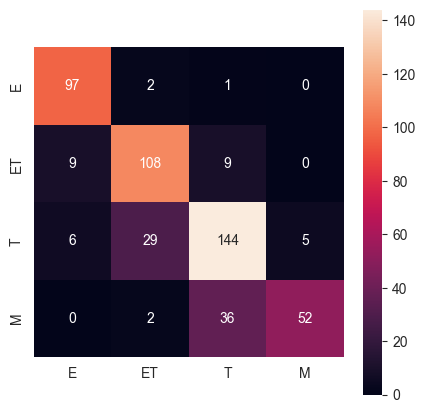

In [330]:
knn = KNeighborsClassifier(n_neighbors=k_to_be)
knn.fit(train_x, train_y)
y_pred = knn.predict(test_x)
# print the score
print('accuracy: ', knn.score(test_x, test_y))

print(classification_report(test_y, y_pred, target_names=ENCODING_LABELS))

cfm = confusion_matrix(test_y, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
            annot=True, fmt='d', square=True)
pass

### 3. Naive Bayes

In [336]:
from sklearn.naive_bayes import MultinomialNB

In [349]:
test_df = pd.read_csv("data/test_esrb.csv")[corr_train.columns]
test_df.esrb_rating = test_df.esrb_rating.replace(encoding)

test_x = test_df.drop(['esrb_rating'], axis=1)
test_y = test_df['esrb_rating']

In [350]:
train_x = corr_train.drop(columns="esrb_rating")
train_y = corr_train["esrb_rating"]

In [351]:
bayes = mnb = MultinomialNB(alpha=1e-10).fit(train_x, train_y)
scores = cross_val_score(bayes, train_x, train_y, cv=5, scoring="accuracy")
    
print(f"Mean Accuracy: {np.mean(scores):.3f}")


Mean Accuracy: 0.684


              precision    recall  f1-score   support

           E       0.93      0.74      0.82       100
          ET       0.30      0.02      0.04       126
           T       0.49      0.88      0.63       184
           M       0.84      0.73      0.78        90

    accuracy                           0.61       500
   macro avg       0.64      0.59      0.57       500
weighted avg       0.59      0.61      0.55       500

Accuracy:  0.608


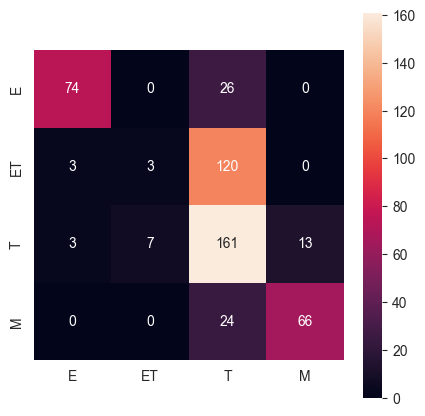

In [354]:
y_pred = bayes.predict(test_x)
print(classification_report(test_y, y_pred, target_names=ENCODING_LABELS))
print('Accuracy: ', bayes.score(test_x, test_y))
cfm = confusion_matrix(test_y, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(
    pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
    annot=True,
    fmt="d",
    square=True,
)

plt.show()

## Using RandomForest Features

### 1. Support Vector Machine

In [296]:
train_x = rf_train.drop(columns="esrb_rating")
train_y = rf_train["esrb_rating"]

ENCODING_LABELS = list(encoding.keys())

In [297]:
C = np.linspace(0.1, 100, 10)
degree = [2, 3, 4, 5, 6]
gamma = list(np.round(np.linspace(0.1, 10, 10), 3))
gamma.append('scale')
gamma.append('auto')
kernel = ['poly', 'rbf', 'sigmoid']

param_grid = {'C': C, 'degree': degree, 'gamma': gamma, 'kernel': kernel}
print(param_grid)

{'C': array([  0.1,  11.2,  22.3,  33.4,  44.5,  55.6,  66.7,  77.8,  88.9,
       100. ]), 'degree': [2, 3, 4, 5, 6], 'gamma': [0.1, 1.2, 2.3, 3.4, 4.5, 5.6, 6.7, 7.8, 8.9, 10.0, 'scale', 'auto'], 'kernel': ['poly', 'rbf', 'sigmoid']}


In [298]:
svm_model = HalvingGridSearchCV(
    SVC(), 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=20,
    refit=True,
)

svm_model.fit(train_x, train_y)

HalvingGridSearchCV(estimator=SVC(), n_jobs=20,
                    param_grid={'C': array([  0.1,  11.2,  22.3,  33.4,  44.5,  55.6,  66.7,  77.8,  88.9,
       100. ]),
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.1, 1.2, 2.3, 3.4, 4.5, 5.6, 6.7,
                                          7.8, 8.9, 10.0, 'scale', 'auto'],
                                'kernel': ['poly', 'rbf', 'sigmoid']},
                    scoring='accuracy')

In [299]:
print("Best parameters:", svm_model.best_params_)
best_svm_model = svm_model.best_estimator_

Best parameters: {'C': 11.200000000000001, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}


In [301]:
test_df = pd.read_csv("data/test_esrb.csv")[rf_train.columns]
test_df.esrb_rating = test_df.esrb_rating.replace(encoding)

test_x = test_df.drop(['esrb_rating'], axis=1)
test_y = test_df['esrb_rating']

              precision    recall  f1-score   support

           E       0.96      0.95      0.95       100
          ET       0.83      0.82      0.82       126
           T       0.79      0.85      0.82       184
           M       0.87      0.74      0.80        90

    accuracy                           0.84       500
   macro avg       0.86      0.84      0.85       500
weighted avg       0.85      0.84      0.84       500



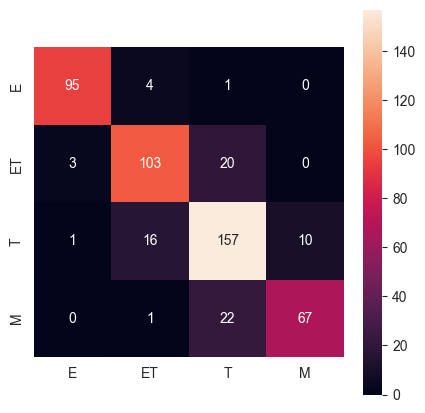

In [302]:
preds = best_svm_model.predict(test_x)
print(classification_report(test_y, preds, target_names=ENCODING_LABELS))

cfm = confusion_matrix(test_y, preds)

plt.figure(figsize=(5, 5))
sns.heatmap(pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
            annot=True, fmt='d', square=True)


### 2. kNN

Making test and train data and labels

In [331]:
train_x = rf_train.drop(columns="esrb_rating")
train_y = rf_train["esrb_rating"]

In [332]:
test_df = pd.read_csv("data/test_esrb.csv")[rf_train.columns]
test_df.esrb_rating = test_df.esrb_rating.replace(encoding)

test_x = test_df.drop(['esrb_rating'], axis=1)
test_y = test_df['esrb_rating']

Using k-fold cross-validation with k from 1 to 20.

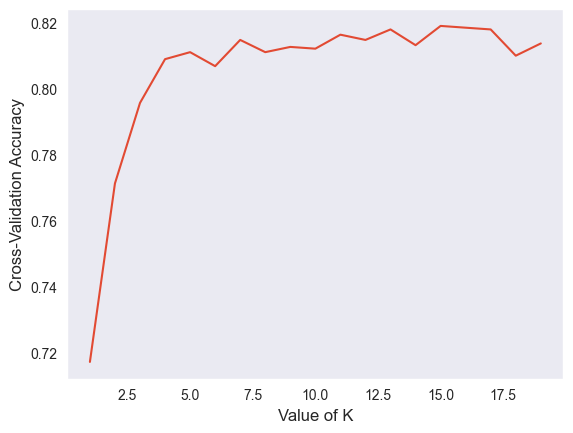

In [333]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_range = range(1, 20)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_x, train_y, cv=5, scoring="accuracy")
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores)
plt.xlabel("Value of K")
plt.ylabel("Cross-Validation Accuracy")
plt.show()


In [334]:
k_to_be = np.argmax(k_scores) + 1
print("Best k:",k_to_be)
print("Accuracy:", max(k_scores))


Best k: 15
Accuracy: 0.8189690258655776


Using best k to run kNN on test data

accuracy:  0.802
              precision    recall  f1-score   support

           E       0.87      0.97      0.92       100
          ET       0.77      0.86      0.81       126
           T       0.76      0.78      0.77       184
           M       0.91      0.58      0.71        90

    accuracy                           0.80       500
   macro avg       0.83      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500



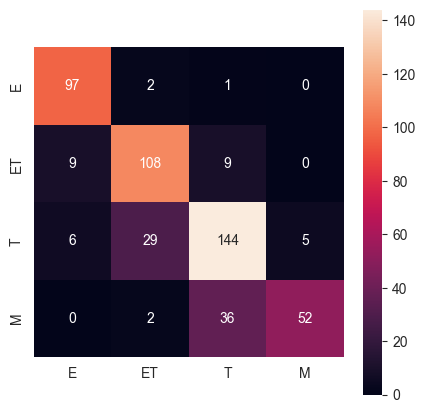

In [335]:
knn = KNeighborsClassifier(n_neighbors=k_to_be)
knn.fit(train_x, train_y)
y_pred = knn.predict(test_x)
# print the score
print('accuracy: ', knn.score(test_x, test_y))

print(classification_report(test_y, y_pred, target_names=ENCODING_LABELS))

cfm = confusion_matrix(test_y, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
            annot=True, fmt='d', square=True)
pass

### 3. Naive Bayes

In [361]:
test_df = pd.read_csv("data/test_esrb.csv")[rf_train.columns]
test_df.esrb_rating = test_df.esrb_rating.replace(encoding)

test_x = test_df.drop(['esrb_rating'], axis=1)
test_y = test_df['esrb_rating']

In [362]:
train_x = rf_train.drop(columns="esrb_rating")
train_y = rf_train["esrb_rating"]

In [363]:
bayes = mnb = MultinomialNB(alpha=1e-10).fit(train_x, train_y)
scores = cross_val_score(bayes, train_x, train_y, cv=5, scoring="accuracy")
    
print(f"Mean Accuracy: {np.mean(scores):.3f}")


Mean Accuracy: 0.836


              precision    recall  f1-score   support

           E       0.97      0.87      0.92       100
          ET       0.79      0.86      0.82       126
           T       0.75      0.80      0.77       184
           M       0.83      0.69      0.75        90

    accuracy                           0.81       500
   macro avg       0.83      0.81      0.82       500
weighted avg       0.82      0.81      0.81       500

Accuracy:  0.81


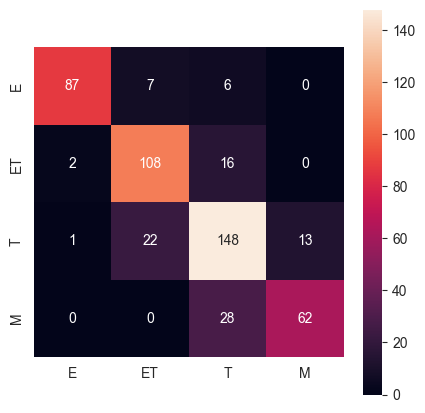

In [364]:
y_pred = bayes.predict(test_x)
print(classification_report(test_y, y_pred, target_names=ENCODING_LABELS))
print('Accuracy: ', bayes.score(test_x, test_y))
cfm = confusion_matrix(test_y, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(
    pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
    annot=True,
    fmt="d",
    square=True,
)

plt.show()


# Analysing the results

From these results we can see that features selected by using random forests tend to be better than features selected based on correlations. This was true for each of the three models used i.e. kNN, Naive Bayes, and SVM.

Moreover, from the three models tested, the ranking of the best models based on precision, f1-score and recall
1. Support Vector Machine
2. Naive Bayes 
3. k-nearest-neighbors

# Which features are most Vital in determining a games rating?  

Based on the results of our experimentation, with different methods of feature selection, we have shortlisted the top 10 features that play the greatest part in determining the rating of a game are the following (ranked from highest to lowest importance)

1. no_descriptors           
2. strong_language          
3. fantasy_violence         
4. blood                    
5. blood_and_gore           
6. mild_fantasy_violence    
7. suggestive_themes        
8. violence                 
9. language                 
10. strong_sexual_content

Most of the decision process is completed based on these features. We can visualise this in the following decision tree

In [377]:
from sklearn import tree
import graphviz

train_x = rf_train.drop(columns="esrb_rating")
train_y = rf_train["esrb_rating"]

clf = tree.DecisionTreeClassifier(max_depth=5).fit(train_x, train_y)

temp = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(temp)
graph.render("iris")

# tree.plot_tree(clf)

'iris.pdf'

# Can we Predict a games ratings based on the given attributes? 

We can indeed make predictions given the above mentioned data features of accuracies >= 80% depending on the model we choose to use. Perhaps with more training data or a more complex ML model (like deep neural networks) we could attain even better results in the prediction of ESRB rating